In [14]:
import sys
import os

sys.path.append(os.path.abspath("..")) 

import torch
from engine import DatasetProvider, Trainer, DatasetName
from models.LeNet import LeNetV2
from utils.get_gpu import get_gpu
from utils.count_params import count_params
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
dataset = DatasetProvider(dataset_name=DatasetName.MNIST, batch_size=256, padding=2)

dataset

In [3]:
model = LeNetV2(10)

In [4]:
model.net

Sequential(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
count_params(model.net)

Layer Name      | weight       | bias         | Total     
----------------------------------------------------------
conv1           | 150          | 6            | 156       
conv2           | 2400         | 16           | 2416      
fc1             | 48000        | 120          | 48120     
fc2             | 10080        | 84           | 10164     
fc3             | 840          | 10           | 850       
----------------------------------------------------------
TOTAL           |                              | 61706     


In [6]:
trainer = Trainer(
    model=model,
    dataset=dataset,
    loss_name="cross_entropy",
    optimizer_name="adam",
    device=get_gpu(),
    lr=0.0001
)

╭─ Experiment Config ─╮
│ Starting Training   │
│ Model: LeNetV2      │
│ Dataset: mnist      │
│ Device: mps         │
╰─────────────────────╯

In [7]:
trainer.train(max_epochs=50)

Output()

✔ Training Complete!

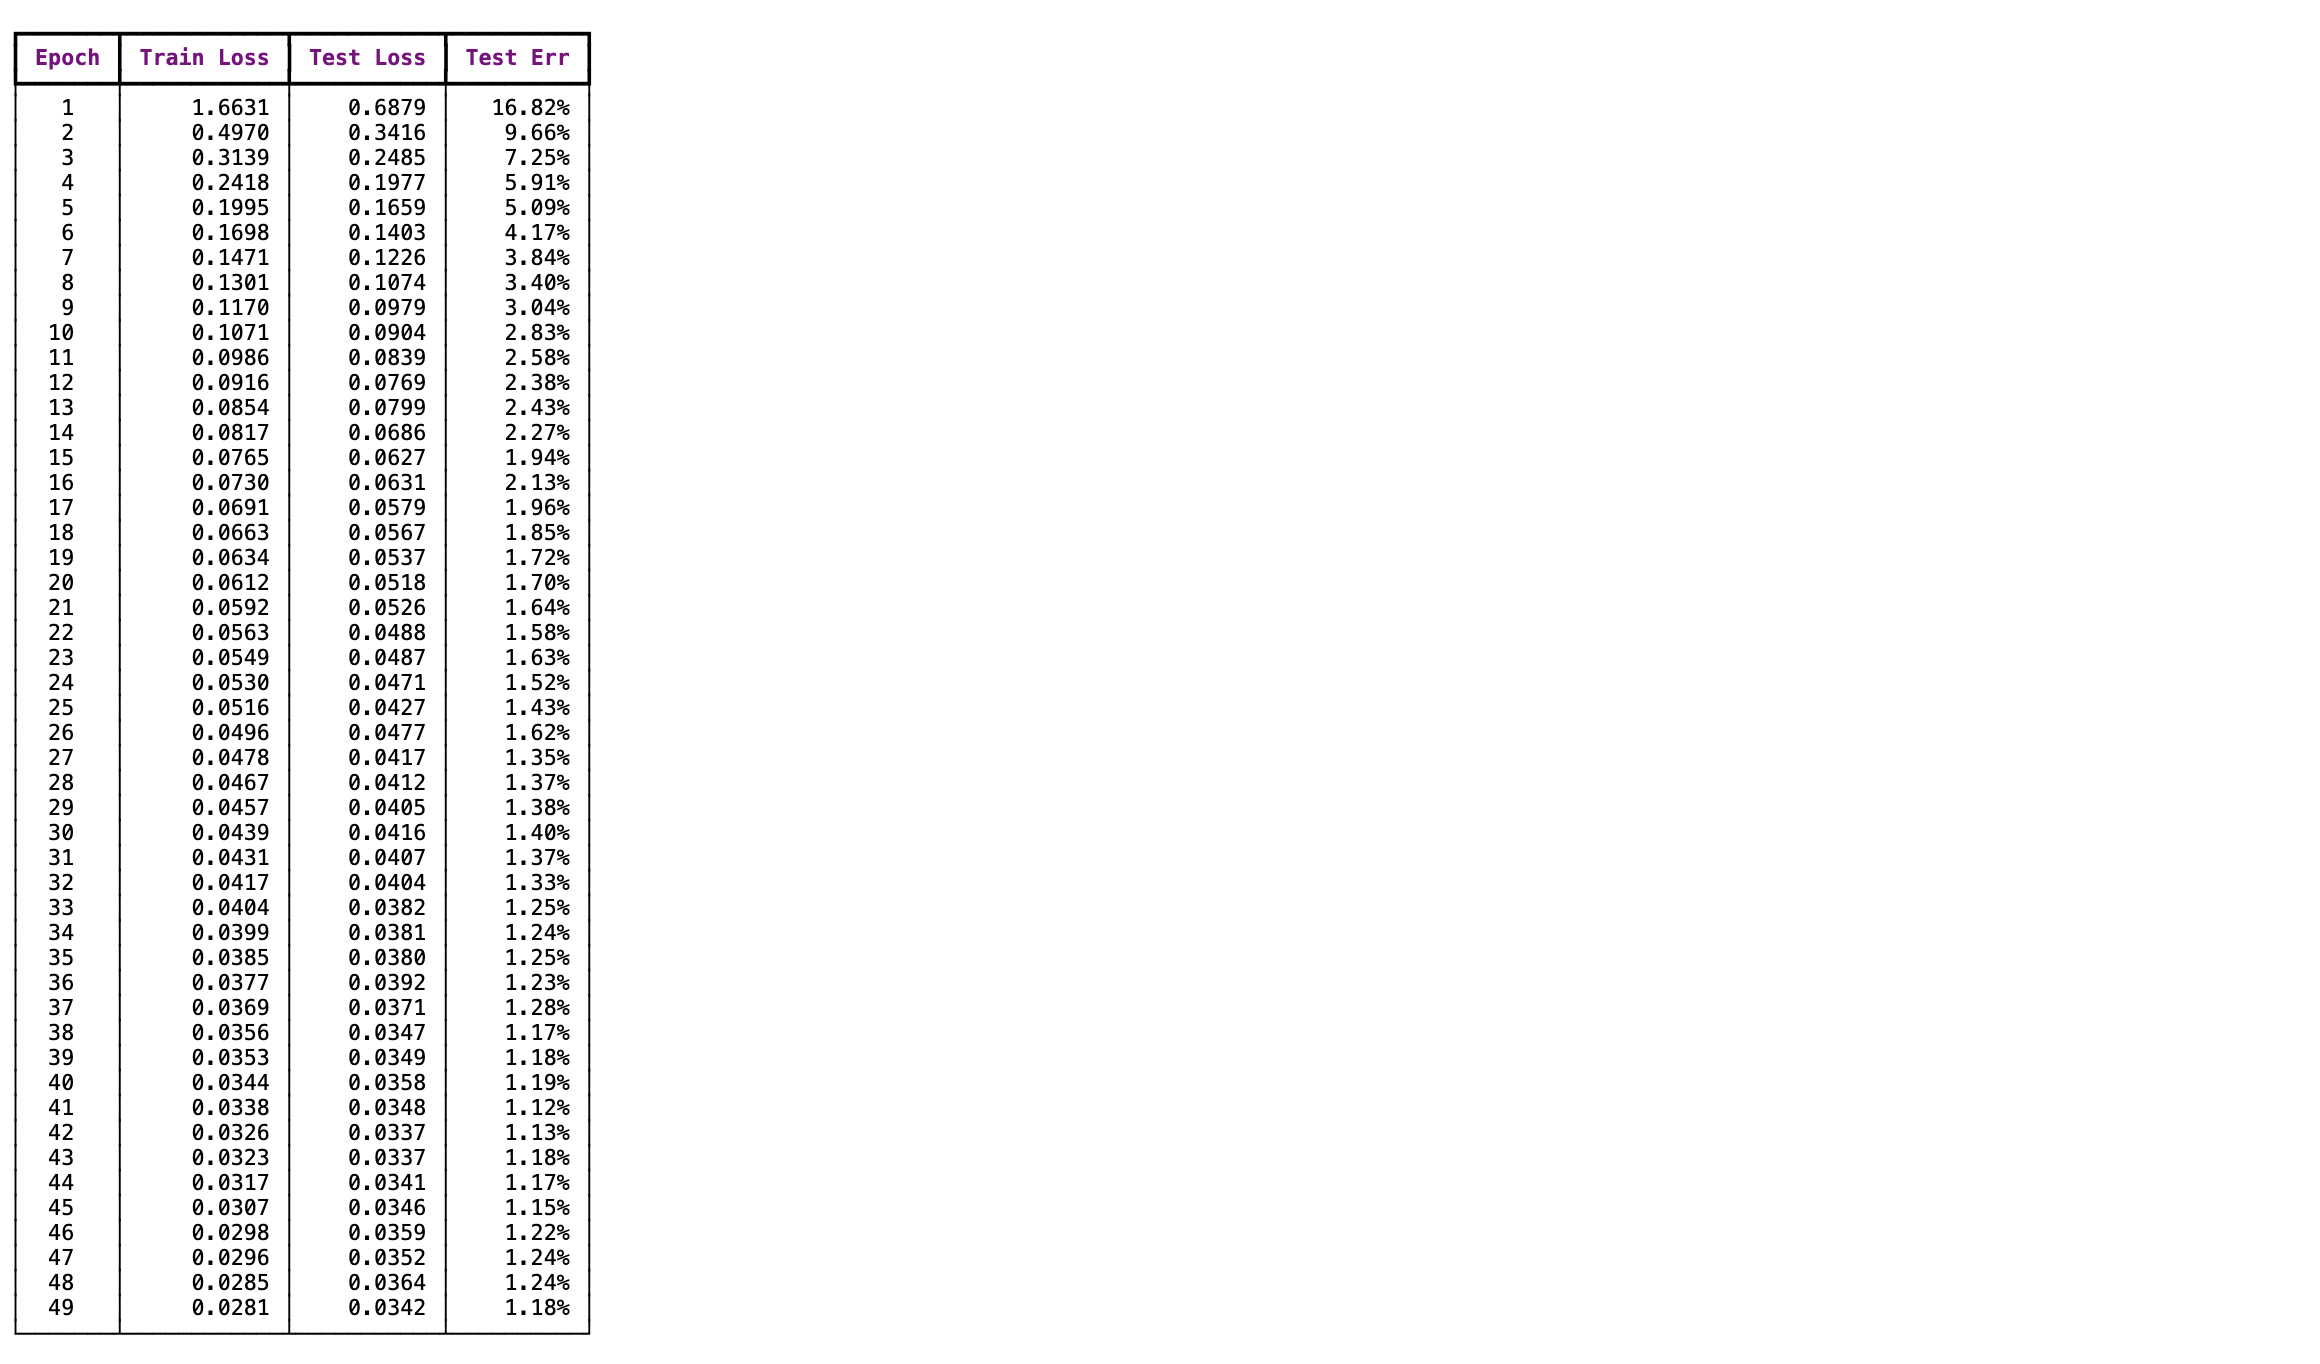

In [9]:
trainer = Trainer(
    model=model,
    dataset=dataset,
    loss_name="cross_entropy",
    optimizer_name="adam",
    device=get_gpu(),
    lr=0.00001
)

╭─ Experiment Config ─╮
│ Starting Training   │
│ Model: LeNetV2      │
│ Dataset: mnist      │
│ Device: mps         │
╰─────────────────────╯

In [10]:
trainer.train(max_epochs=20)

Output()

✔ Training Complete!

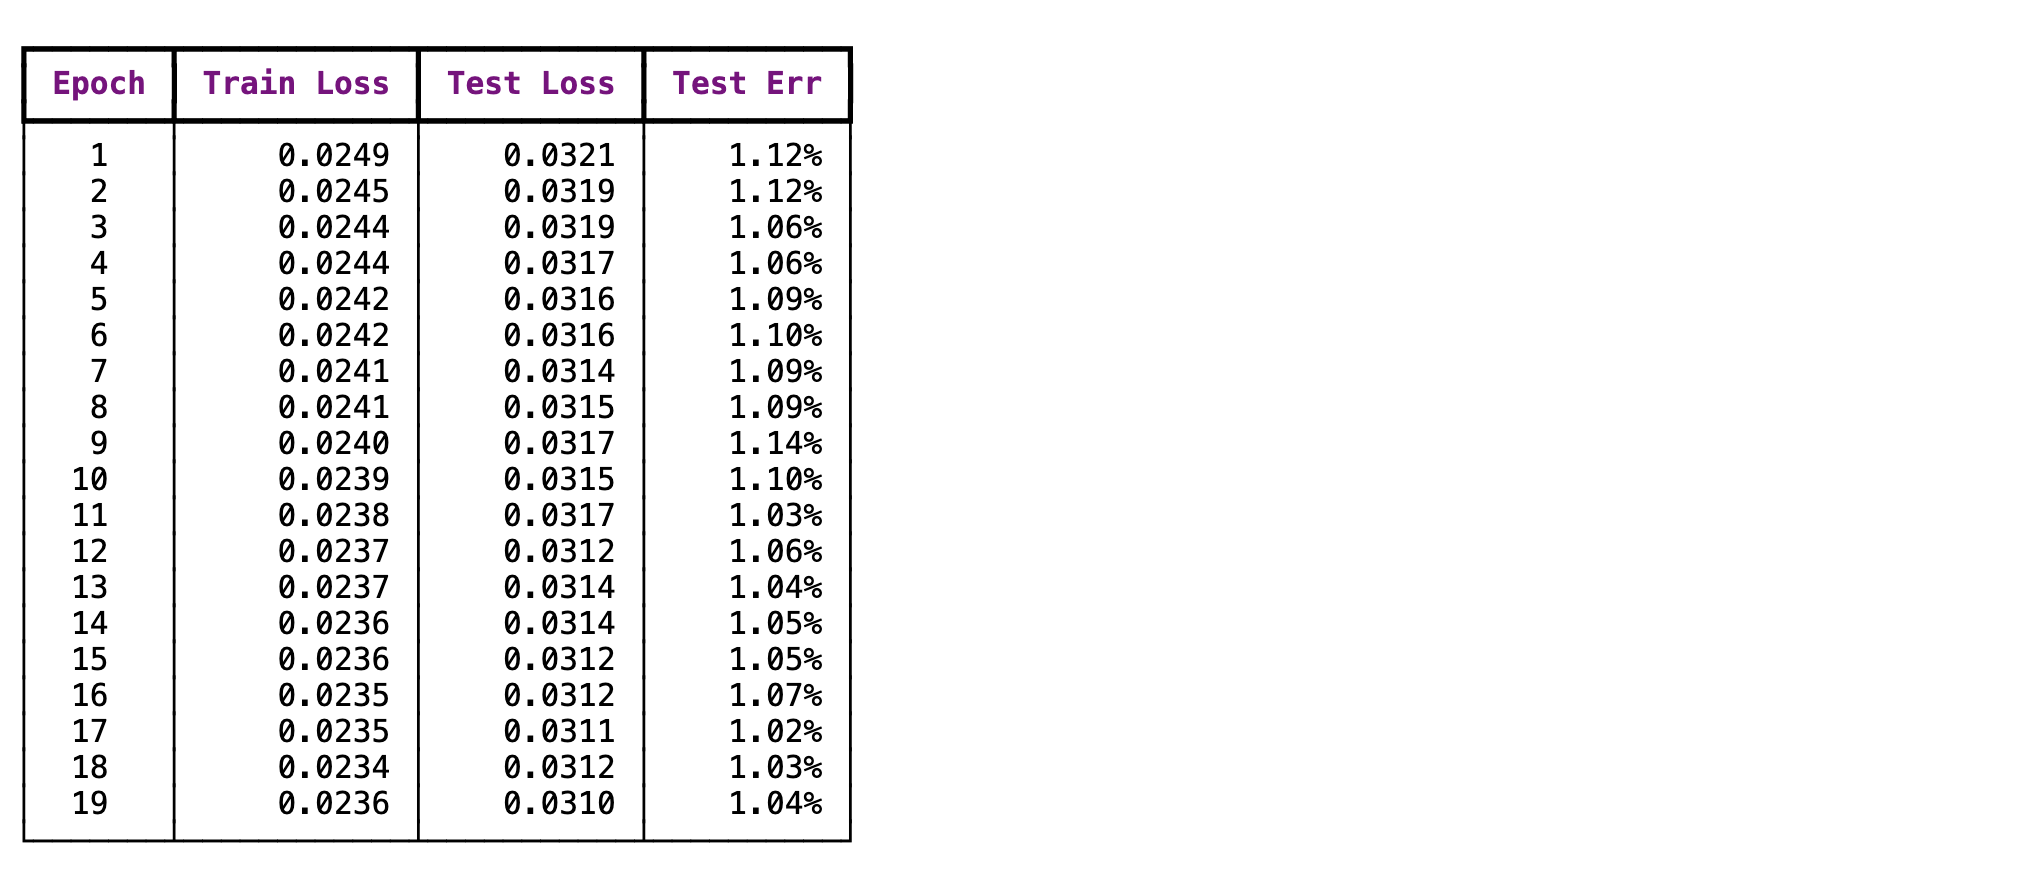

In [11]:
torch.save(model.state_dict(), "lenet_v2.pth")

In [4]:
model = LeNetV2(out_features=10)
model.load_state_dict(torch.load("lenet_v2.pth"))

<All keys matched successfully>

In [40]:
model = model.to(device=get_gpu())

total = 0
stats = {
    "pred": [],
    "prob_of_pred": [],
    "true": [],
    "result": [],
}

for X_test, y_test in dataset.testloader:
    X_test, y_test = X_test.to(get_gpu()), y_test.to(get_gpu())

    y_hat = model.forward(X_test)
    y_probs = torch.max(F.softmax(y_hat, dim=1), dim=1).values

    y_pred = torch.argmax(y_hat, dim=1)
    result = (y_pred != y_test).int()
    total += y_test.shape[0]

    stats["pred"].append(y_pred)
    stats["prob_of_pred"].append(y_probs)
    stats["true"].append(y_test)
    stats["result"].append(result)

In [41]:
for key, value in stats.items():
    stats[key] = torch.cat(value)

In [42]:
print(f"Total number of test samples: {total}")
print(f"Number of incorrect_predictions: {stats['result'].sum()}")

Total number of test samples: 10000
Number of incorrect_predictions: 106


In [56]:
incorr_preds_idx = torch.where(stats["result"] == 1)[0]

In [66]:
probs, sorted_idx = stats["prob_of_pred"][incorr_preds_idx].sort(descending=True)
top_5_max_probs = probs[:5]
top_5_local_idx = sorted_idx[:5]
top_5_global_idx = incorr_preds_idx[top_5_local_idx]

In [69]:
pred = stats["pred"][top_5_global_idx]
prob_of_pred = stats["prob_of_pred"][top_5_global_idx]
true = stats["true"][top_5_global_idx]

In [71]:
print(f"pred: {pred}")
print(f"prob: {prob_of_pred}")
print(f"true: {true}")

pred: tensor([7, 0, 6, 0, 4], device='mps:0')
prob: tensor([0.9985, 0.9972, 0.9951, 0.9905, 0.9902], device='mps:0',
       grad_fn=<IndexBackward0>)
true: tensor([2, 8, 5, 5, 6], device='mps:0')


In [74]:
test_dataset = dataset.testloader.dataset
mistake_images = [test_dataset[idx][0] for idx in top_5_global_idx]
mistake_labels = [test_dataset[idx][1] for idx in top_5_global_idx]

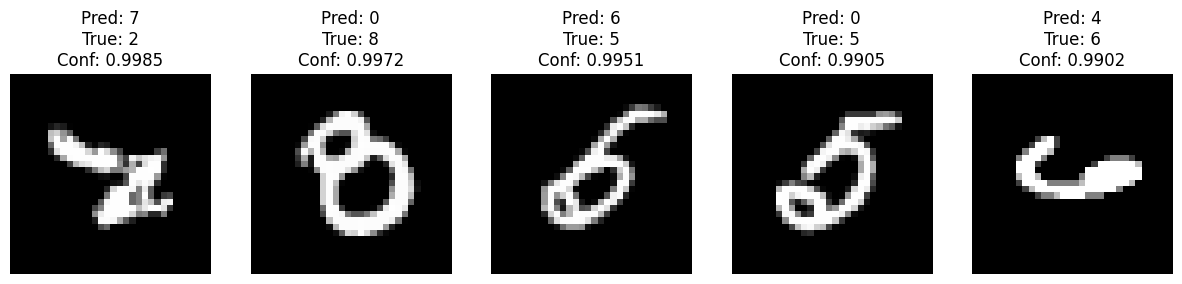

In [76]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
test_dataset = dataset.testloader.dataset

for i, global_idx in enumerate(top_5_global_idx):
    img, label = test_dataset[global_idx.item()]
    
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"Pred: {pred[i]}\nTrue: {label}\nConf: {top_5_max_probs[i]:.4f}")
    axes[i].axis('off')

plt.show()

And here we see that some of this numbers hard to recognize even for human